In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'C:/Users/mayan/Desktop/TKS/Artificial_Intelligence/Dog_Cat_Classifier/data/train'
TEST_DIR = 'C:/Users/mayan/Desktop/TKS/Artificial_Intelligence/Dog_Cat_Classifier/data/test'
IMG_SIZE = 50
LR = 0.001

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic')

In [11]:
# 1 hot encoding
def label_img(img):
    #(dog/cat).  #  . jpg
    #   (-3)   (-2)  (-1) 
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [12]:
def create_train_data():
    training_data = []
    # tqdm() is unnecessary but just makes a nice loadnig bar while running the loop
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        
        #cv2.imread() reads the image
        #cv2.IMREAD_GRAYSCALE turns it to grayscale
        #cv2.resize(img, (l,w)) resizes the image
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        
        #add cleaned data to array of data
        training_data.append([np.array(img), np.array(label)])
    
    #Randomize the order of the data
    shuffle(training_data)
    
    #save training data as a numpy file so process doesn't have to be redone
    np.save('train_data.npy', training_data)
    return training_data

In [13]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy',testing_data)
    return testing_data

In [14]:
#Only need to do once
#train_data = create_train_data()

In [3]:
#if data already processed
train_data = np.load('train_data.npy')

In [16]:
#Only need to do once
#test_data = process_test_data()

In [4]:
testing_data = np.load('test_data.npy')

In [5]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
# Continue progress if some epochs already ran 
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from C:\Users\mayan\Desktop\TKS\Artificial_Intelligence\Dog_Cat_Classifier\dogsvscats-0.001-6conv-basic.model
model loaded!


In [11]:
train = train_data[:-500]
test = train_data[-500:]

In [12]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #i[0] is the image data (pixels)
Y = [i[1] for i in train] #i[1] is the image label

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #i[0] is the image data (pixels)
test_y = [i[1] for i in test] #i[1] is the image label

In [26]:
# Train model
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}),
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 13404  | total loss: 0.14163 | time: 106.755s
| Adam | epoch: 031 | loss: 0.14163 - acc: 0.9407 -- iter: 24448/24500
Training Step: 13405  | total loss: 0.14705 | time: 108.018s
| Adam | epoch: 031 | loss: 0.14705 - acc: 0.9388 | val_loss: 0.77325 - val_acc: 0.8040 -- iter: 24500/24500
--


In [23]:
# tensorboard --logdir=foo:C:\Users\mayan\Desktop\TKS\Artificial_Intelligence\Dog_Cat_Classifier\log

In [24]:
# Save model after training
# model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\mayan\Desktop\TKS\Artificial_Intelligence\Dog_Cat_Classifier\dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


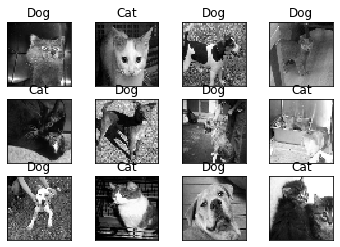

In [24]:
import matplotlib.pyplot as plt

test_data = np.load('test_data.npy')
#train_data = create_train_data()
fig = plt.figure()

for num, data, in enumerate(test_data[1100:1112]):
    #cat: [1,0]
    #dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label="Dog"
    else: str_label = "Cat"
        
    y.imshow(orig, cmap="gray")
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()